# Кластеризация
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][HW02] <ФИО>`, где вместо `<ФИО>` указаны фамилия и имя__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов к задаче уменьшения цветности изображения.

In [160]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
from collections import deque
from typing import NoReturn, Dict

ModuleNotFoundError: No module named 'cv2'

In [4]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

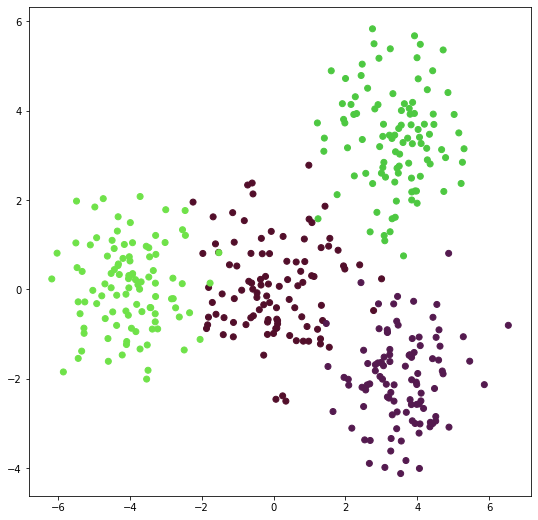

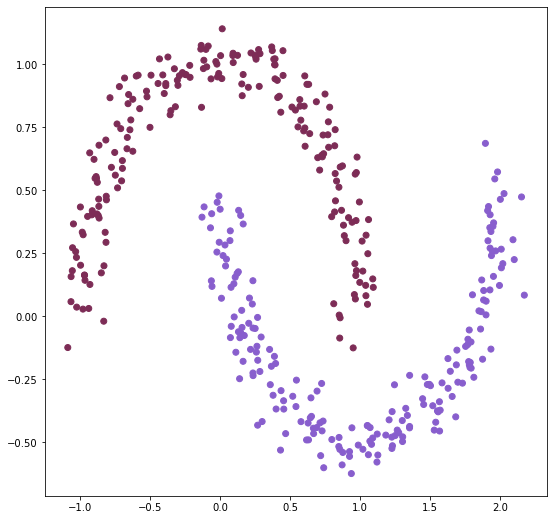

In [5]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 1 (3 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

__Не забудте реинициализировать пустые кластеры!__

In [177]:
# generates a random point with limited abs by 6 in every dimensions
def generate_random_point(dimensions_amount):
    return (np.random.rand(1, dimensions_amount)[0] - (np.ones(dimensions_amount) - 1/2)) * 12

class KMeans:
    n_clusters = None
    init = None
    max_iter = None
    
    dimensions_amount = None
    centroids = None
    centroids_with_assigned_points = None

    def __init__(self, n_clusters: int, init: str = "random", 
                 max_iter: int = 300):
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        
    def __generate_point_k_means_pp__(self, X):
        random_point = random.sample(list(X), 1)
        closest_centroids = []
        for x in X:
            closest_centroid = None
            best_distance = 1000000000
            for centroid_index, centroid in enumerate(self.centroids):
                distance = np.sum((centroid - x) ** 2)
                if distance < best_distance:
                    closest_centroid = centroid_index
                    best_distance = distance
            assert closest_centroid is not None
            closest_centroids.append(closest_centroid)
        distance_sum = 0
        for i in range(0, len(closest_centroids)):
            distance_sum += closest_centroids[i]
        threshold = random.randint(0, distance_sum)
        cur = 0
        for i in range(0, len(X)):
            cur += np.sum((closest_centroids[i] - X[i]) ** 2)
            if cur > threshold:
                return X[i]

        
    def __init_centroids__(self, X):
        _, self.dimensions_amount = np.shape(X)
        if self.init == 'random':
            self.centroids = [generate_random_point(self.dimensions_amount) for i in range(0, self.n_clusters)]
        if self.init == 'sample':
            self.centroids = random.sample(list(X), self.n_clusters)
        if self.init == 'k-means++':
            self.centroids = random.sample(list(X), 1)
            for i in range(0, self.n_clusters - 1):
                self.centroids.append(self.__generate_point_k_means_pp__(X))
    
    def __assign_points__(self, X):
        result = {}
        for point_index, x in enumerate(X):
            best_distance = 1000000000
            best_centroid_index = None
            for index, centroid in enumerate(self.centroids):
                distance = np.sum((centroid - x) ** 2)
                if distance < best_distance:
                    best_centroid_index = index
                    best_distance = distance
            assert best_centroid_index is not None
            if best_centroid_index not in result:
                result[best_centroid_index] = []
            result[best_centroid_index].append(point_index)
        return result
    
    def __find_empty_centroids__(self):
        result = []
        assert self.centroids is not None
        assert self.centroids_with_assigned_points is not None
        for i in range(0, len(self.centroids)):
            if i not in self.centroids_with_assigned_points:
                result.append(i)
        return result
    
    def __rebalance_centroids__(self, X):
        for centroid_index, centroid in enumerate(self.centroids):
            points = self.centroids_with_assigned_points[centroid_index]
            assert len(points) > 0
            new_centroid = np.zeros(self.dimensions_amount)
            for point in points:
                new_centroid += point
            new_centroid /= len(points)
            self.centroids[centroid_index] = new_centroid
            
    def __fix_empty_centroids__(self, X):
        empty_centroids = self.__find_empty_centroids__()
        while len(empty_centroids) > 0:
            for centroid_index in empty_centroids:
                if self.init == 'random':
                    self.centroids[centroid_index] = generate_random_point(self.dimensions_amount)
                if self.init == 'sample':
                    self.centroids[centroid_index] = random.sample(list(X), 1)
                if self.init == 'k-means++':
                    self.centroids[centroid_index] = self.__generate_point_k_means_pp__(X)
            self.centroids_with_assigned_points = self.__assign_points__(X)
            empty_centroids = self.__find_empty_centroids__()
        
    def fit(self, X: np.array, y = None) -> NoReturn:
        self.__init_centroids__(X)
        self.centroids_with_assigned_points = self.__assign_points__(X)
        self.__fix_empty_centroids__(X)
        for i in range(0, self.max_iter):
            self.__rebalance_centroids__(X)
            self.centroids_with_assigned_points = self.__assign_points__(X)
            self.__fix_empty_centroids__(X)


            
    def __get_clusters__(self, ):
        result = {}
        for point_index, x in enumerate(X):
            best_distance = 1000000000
            best_centroid_index = None
            for index, centroid in enumerate(self.centroids):
                distance = np.sum((centroid - x) ** 2)
                if distance < best_distance:
                    best_centroid_index = index
                    best_distance = distance
            assert best_centroid_index is not None
            if best_centroid_index not in result:
                result[best_centroid_index] = []
            result[best_centroid_index].append(point_index)
        return result
    
    def predict(self, X: np.array) -> np.array:
        result = []
        for point_index, x in enumerate(X):
            best_distance = 1000000000
            best_centroid = None
            for centroid_index, centroid in enumerate(self.centroids):
                distance = np.sum((centroid - x) ** 2)
                if distance < best_distance:
                    best_distance = distance
                    best_centroid = centroid_index
            assert best_centroid is not None
            result.append(best_centroid)
        return np.array(result)


Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

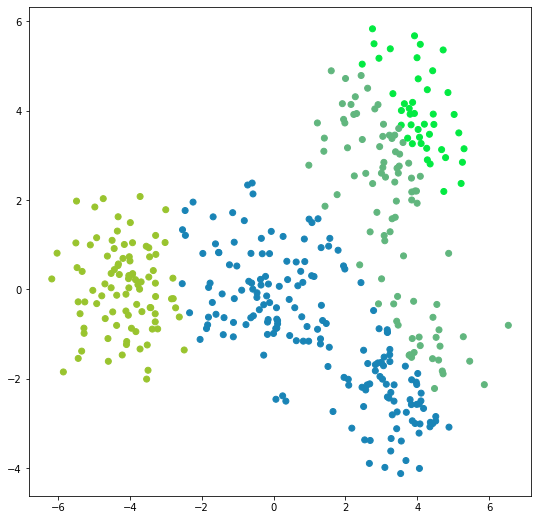

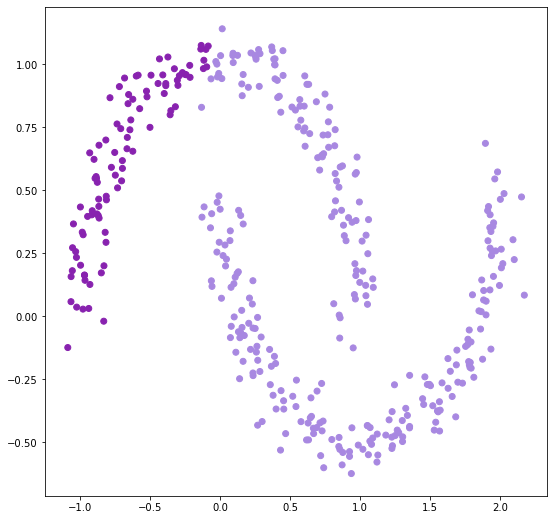

In [178]:
kmeans = KMeans(n_clusters=4, init='sample')
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2, init='k-means++')
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 2 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [16]:
class DBScan:
    tree = None
    eps = None
    min_samples = None
    leaf_size = None
    metric = None

    def __init__(self, eps: float = 0.7, min_samples: int = 5,
                 leaf_size: int = 40, metric: str = "manhattan"):
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric

    def __color_points__(self, point_index: int, points: np.array, labeled_points, cur_label: int):
        queue = deque([point_index])
        while len(queue) > 0:
            next_point_index: int = queue[0]
            queue.popleft()
            labeled_points[next_point_index] = cur_label
            neighbours = self.tree.query_radius(X=[points[next_point_index]], r=self.eps)[0]
            if len(neighbours) < self.min_samples:
                continue
            for neighbour in neighbours:
                if neighbour not in labeled_points:
                    queue.appendleft(neighbour)

    def fit_predict(self, X: np.array, y=None) -> np.array:
        self.tree = KDTree(X, leaf_size=self.leaf_size, metric=self.metric)
        labeled_points = {}
        cur_label = 0
        for index, x in enumerate(X):
            if index in labeled_points:
                continue
            if self.tree.query_radius(X=[x], r=self.eps, count_only=True) < self.min_samples:
                continue
            self.__color_points__(index, X, labeled_points, cur_label)
            cur_label += 1
        return [labeled_points[index] if index in labeled_points is not None else -1 for index in range(0, len(X))]


Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

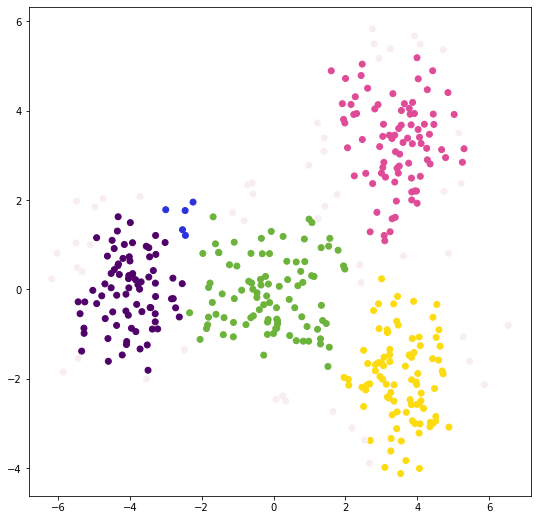

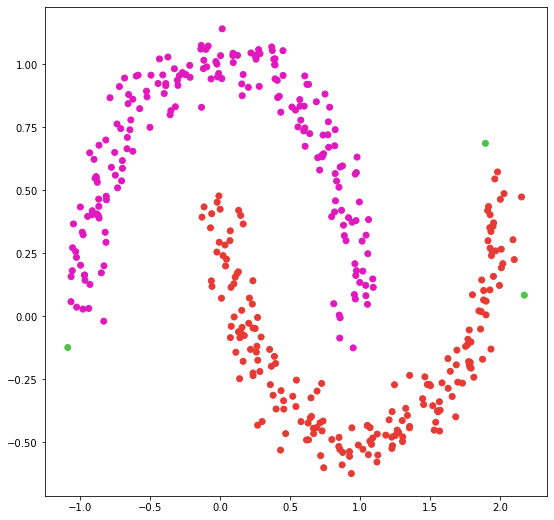

In [17]:
dbscan = DBScan(eps=0.7)
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(eps=0.2)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 3 (3 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [13]:
def get_distance(p1, p2, points):
    return np.sum((points[p1] - points[p2]) ** 2)

def average(cluster1, cluster2, points):
    distances = np.array([])
    for p1 in cluster1:
        for p2 in cluster2:
            distances = np.append(distances, get_distance(p1, p2, points))
    return np.sum(distances) / (float) (len(cluster1) * len(cluster2))

def single(cluster1, cluster2, points):
    distances = np.array([])
    for p1 in cluster1:
        for p2 in cluster2:
            distances = np.append(distances, get_distance(p1, p2, points))
    return np.min(distances)

def complete(cluster1, cluster2, points):
    distances = np.array([])
    for p1 in cluster1:
        for p2 in cluster2:
            distances = np.append(distances, get_distance(p1, p2, points))
    return np.max(distances)

class AgglomertiveClustering:
    
    n_clusters = None
    compare_function = None
    
    def __init__(self, n_clusters: int = 16, linkage: str = 'average'):
        self.n_clusters = n_clusters
        if linkage == 'average':
            self.compare_function = average
        elif linkage == 'single':
            self.compare_function = single
        elif linkage == 'complete':
            self.compare_function = complete
        else:
            assert(False)
    
    def fit_predict(self, X: np.array, y = None) -> np.array:
        clusters = [[index] for index in range(0, len(X))]
        while len(clusters) > self.n_clusters:
            best_dist = 10000000000
            best_pair = None
            for i in range(0, len(clusters)):
                for j in range(i + 1, len(clusters)):
                    comparison_result = self.compare_function(clusters[i], clusters[j], X)
                    if comparison_result < best_dist:
                        best_dist = comparison_result
                        best_pair = (i, j)
            assert(best_pair is not None)
            i = best_pair[0]
            j = best_pair[1]
            new_cluster = clusters[i] + clusters[j]
            clusters[i] = new_cluster
            clusters.pop(j)
        labels = {}
        for cluster_index, cluster in enumerate(clusters):
            for point_index in cluster:
                labels[point_index] = cluster_index
        return [labels[i] for i in range(0, len(X))]


Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

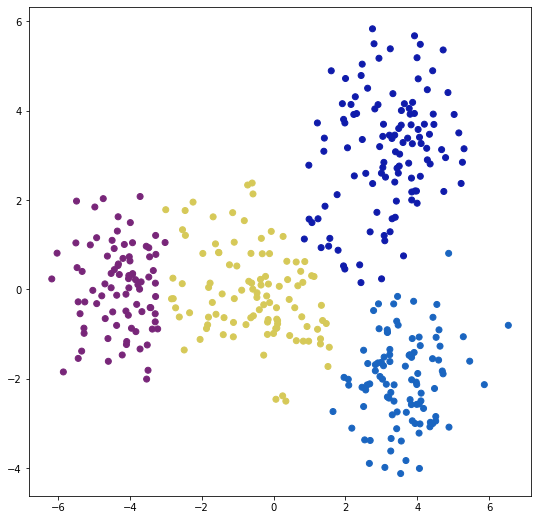

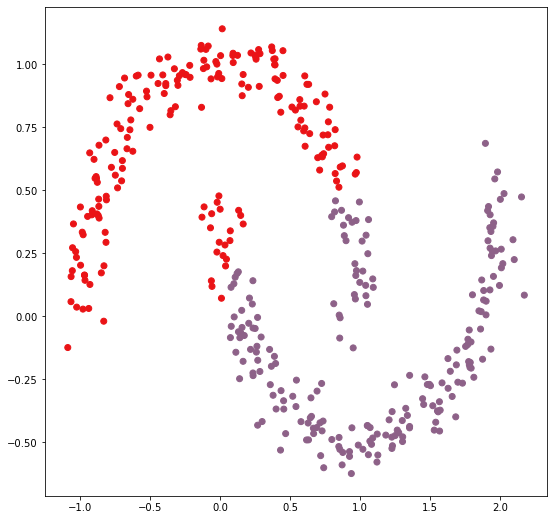

In [14]:
agg_clustering = AgglomertiveClustering(n_clusters=4, linkage ='average')
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2, linkage='complete')
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 4 (1 балл)
Реализуйте методы считывания и записи изображения при помощи библиотеки OpenCV. 

#### Описание методов
`read_image(path)` читает изображение и возвращает его в виде трехмерного numpy массива размера `(N, M, C)`, где `N` и `M` - размеры изображения, а `C` - количество цветов (3 для обычного изображения)
`save_image(image, path)` сохраняет изображение.

__Учтите, что `cv2.imread` считывает изображение в цветовой схеме BGR. После считывания необходимо перевести его в RGB и нормализовать__

In [149]:
def read_image(path: str) -> np.array:
    """
    Читает изображение.

    Parameters
    ----------
    path : str
        Путь к изображению.
    
    Return
    ------
    image : np.array
        Трехмерный массив размера (N, M, C), 
        где N и M - размеры изображения, 
        а C - количество цветов (3 для обычного изображения).
    """
    image = cv2.imread('./emma.jpg', cv2.IMREAD_COLOR)
    return image

def show_image(image: np.array) -> NoReturn:
    """
    Выводит изображение

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    """
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_image(image: np.array, path: str) -> NoReturn:
    """
    Сохраняет изображение.

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    path : str
        Путь для сохранения.
    """
    raise NotImplementedError()

In [150]:
show_image(read_image("./image.png"))

NameError: name 'cv2' is not defined

### Задание 5 (1 балл)
Реализуйте функцию, которая будет кластеризовать цвета изображения одним из реализованных алгоритмов. Интерфейс этой функции можно менять. Функция должна возвращать новое изображение, в котором цвета заменены на цвета кластеров.

Затем примените ее к цветам изображения.

__Примечание: это задание проще всего выполнить при помощи KMeans__

In [ ]:
def clusterize_image(image, **kwargs):
    cluster_colors = None # color of each cluster
    clusters = None # Cluster labels for each pixel in flattened image
    recolored = None # Image with pixel colors assigned to corresponding cluster colors
    
    clusters_statistics(image.reshape(-1, 3), cluster_colors, clusters) # Very slow (:
    return recolored

In [ ]:
image = read_image("./image.jpg")
result = clusterize_image(image)
show_image(result)
save_image(result, "result.jpg")